# **Load the dataset**

In [7]:
!pip install scikit-fuzzy

In [8]:
#  Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

#  Load the Dataset
df = pd.read_csv('merged_onion_data.csv')
df.head()


,date,bengaluru_wholesaleprice,bengaluru_retailprice,bengaluru_volume,bengaluru_rainfall,diesel_price,mumbai_retailprice,chennai_retailprice
0,2015-01-01,1758,2791,74978,9.0,60.70,2060,2924
1,2015-02-01,1815,2750,42164,0.0,65.19,2227,3100
2,2015-03-01,1576,2396,41339,37.7,63.30,1977,2824
3,2015-04-01,1455,2260,43534,225.8,65.67,1717,2635
4,2015-05-01,1725,2458,44227,178.4,67.05,1854,2754


In [9]:
#  Explore and Clean the Data
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      67 non-null     object 
 1   bengaluru_wholesaleprice  67 non-null     int64  
 2   bengaluru_retailprice     67 non-null     int64  
 3   bengaluru_volume          67 non-null     int64  
 4   bengaluru_rainfall        67 non-null     float64
 5   diesel_price              67 non-null     float64
 6   mumbai_retailprice        67 non-null     int64  
 7   chennai_retailprice       67 non-null     int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 4.3+ KB


,0
date,0
bengaluru_wholesaleprice,0
bengaluru_retailprice,0
bengaluru_volume,0
bengaluru_rainfall,0
diesel_price,0
mumbai_retailprice,0
chennai_retailprice,0


In [10]:
# Handle Missing Values
df = df.fillna(method='ffill')


/tmp/ipython-input-10-714855102.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


# **Feature-Target Split**

In [11]:
# Select Features for Clustering
features = df.drop(columns=['bengaluru_retailprice', 'date'])
target = df['bengaluru_retailprice']

# **Normalize Input Features**

In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# **Apply Fuzzy C-Means Clustering**

In [13]:
# Number of Clusters
k = 3
# Maximum number of iterations
MAX_ITER = 100
# Number of data points
n = len(df)
# Fuzzy parameter
m = 1.7 #Select a value greater than 1 else it will be knn

In [14]:
n_clusters = 3
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    scaled_data.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None
)

# **Assign Cluster Labels to Each Data Point**

In [15]:
cluster_labels = np.argmax(u, axis=0)
df['Cluster'] = cluster_labels


# **Visualize Clusters**

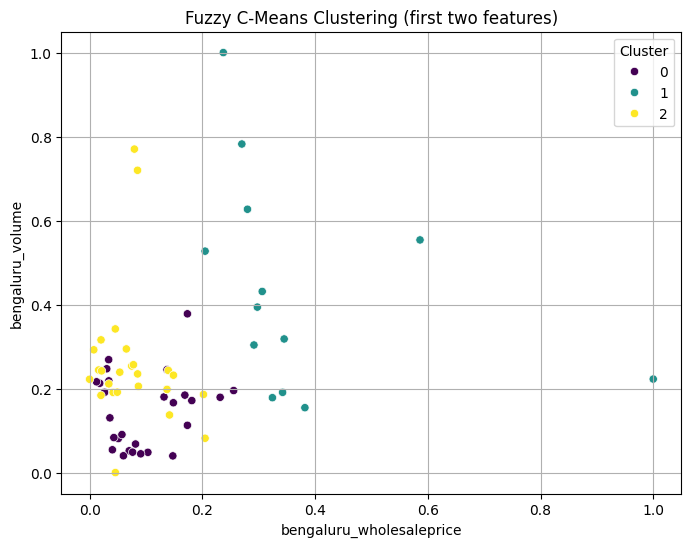

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_data[:, 0], y=scaled_data[:, 1], hue=cluster_labels, palette='viridis'
)
plt.title('Fuzzy C-Means Clustering (first two features)')
plt.xlabel(features.columns[0])
plt.ylabel(features.columns[1])
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# **Visualize Cluster Centers**

In [17]:
centers = scaler.inverse_transform(cntr)

for i, center in enumerate(centers):
    print(f"Cluster {i} Center:")
    for col, val in zip(features.columns, center):
        print(f"  {col}: {val:.2f}")
    print()


Cluster 0 Center:
  bengaluru_wholesaleprice: 1216.62
  bengaluru_volume: 38691.98
  bengaluru_rainfall: 61.47
  diesel_price: 68.07
  mumbai_retailprice: 1737.20
  chennai_retailprice: 2574.51

Cluster 1 Center:
  bengaluru_wholesaleprice: 2914.36
  bengaluru_volume: 81962.45
  bengaluru_rainfall: 115.85
  diesel_price: 78.59
  mumbai_retailprice: 5439.60
  chennai_retailprice: 6168.78

Cluster 2 Center:
  bengaluru_wholesaleprice: 1089.79
  bengaluru_volume: 54631.21
  bengaluru_rainfall: 81.70
  diesel_price: 88.75
  mumbai_retailprice: 2013.42
  chennai_retailprice: 2829.99



# **Visualize Membership Strength**

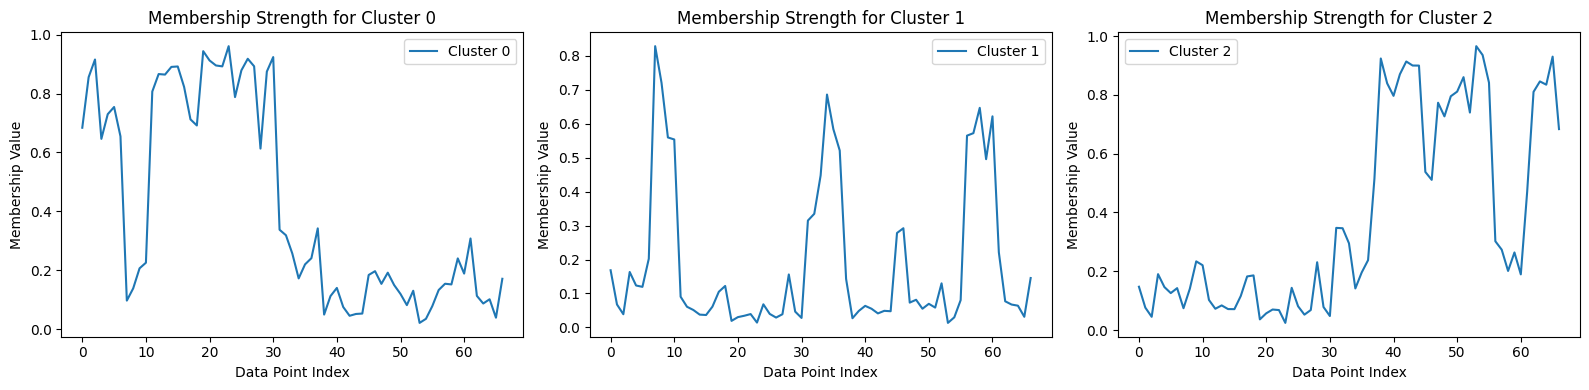

In [18]:
fig, axes = plt.subplots(1, n_clusters, figsize=(16, 4))
for i in range(n_clusters):
    axes[i].plot(u[i], label=f'Cluster {i}')
    axes[i].set_title(f'Membership Strength for Cluster {i}')
    axes[i].set_xlabel('Data Point Index')
    axes[i].set_ylabel('Membership Value')
    axes[i].legend()
plt.tight_layout()
plt.show()


# **Map Clusters to Estimated Prices**

In [19]:
#  Map each cluster to average 'bengaluru_retailprice'
cluster_price_map = df.groupby('Cluster')['bengaluru_retailprice'].mean().to_dict()
print("Cluster to Average Price Mapping:", cluster_price_map)

#  Predict price using cluster labels
df['predicted_price'] = df['Cluster'].map(cluster_price_map)

print("Cluster to Estimated Retail Price Mapping:")
for cluster, price in cluster_price_map.items():
    print(f"Cluster {cluster}: ₹{price:.2f}")

Cluster to Average Price Mapping: {0: 2112.5555555555557, 1: 5004.923076923077, 2: 1909.0740740740741}
Cluster to Estimated Retail Price Mapping:
Cluster 0: ₹2112.56
Cluster 1: ₹5004.92
Cluster 2: ₹1909.07


# **Predict Prices Using Cluster Mapping**

In [20]:
# Predict retail price for each sample based on its cluster label
y_pred = np.array([cluster_price_map[label] for label in cluster_labels])

# **Evaluate the Fuzzy Model**

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = df['bengaluru_retailprice']
y_pred = df['predicted_price']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f" MAE  = {mae:.2f}")
print(f" RMSE = {rmse:.2f}")
print(f" MAPE = {mape:.2f}%")


 MAE  = 685.76
 RMSE = 1050.34
 MAPE = 27.67%


# **Visualize Actual vs Predicted Prices**

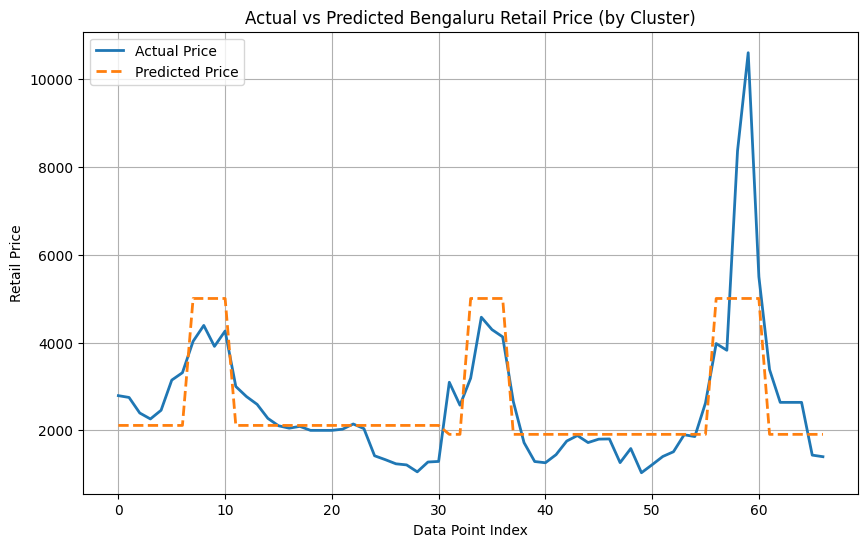

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_true.values, label='Actual Price', linewidth=2)
plt.plot(y_pred.values, label='Predicted Price', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Bengaluru Retail Price (by Cluster)")
plt.xlabel("Data Point Index")
plt.ylabel("Retail Price")
plt.legend()
plt.grid(True)
plt.show()


# **Stream**

In [23]:
#  Install Required Libraries (run once)
!pip install -q ipywidgets scikit-fuzzy plotly

#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from ipywidgets import interact, FileUpload, Dropdown, IntSlider, Output, VBox, Button
from IPython.display import display, clear_output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00


In [24]:
#  UI: File Uploader
upload = FileUpload(accept='.csv', multiple=False)
output = Output()

#  Callback when CSV is uploaded
def handle_upload(change):
    output.clear_output()
    with output:
        # Load CSV
        fname = list(upload.value.keys())[0]
        content = upload.value[fname]['content']
        with open(fname, 'wb') as f:
            f.write(content)
        df = pd.read_csv(fname)

        if 'bengaluru_retailprice' not in df.columns:
            print(" 'bengaluru_retailprice' column not found.")
            return

        print(" CSV loaded successfully!")
        display(df.head())  # Show raw data

        # Proceed to fuzzy logic dashboard
        fuzzy_dashboard(df)

upload.observe(handle_upload, names='value')
display(VBox([upload, output]))

#  Fuzzy Logic Dashboard
def fuzzy_dashboard(df):
    X = df.drop(columns=['bengaluru_retailprice'])

#  Remove non-numeric columns (like 'date')
    X = X.select_dtypes(include=[np.number])
    y = df['bengaluru_retailprice'].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    def run_fuzzy(n_clusters):
        clear_output(wait=True)

        # Clustering
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X_scaled.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000)

        cluster_labels = np.argmax(u, axis=0)
        cluster_prices = {i: y[cluster_labels == i].mean() for i in range(n_clusters)}
        y_pred = np.array([cluster_prices[label] for label in cluster_labels])

        # Metrics
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mape = np.mean(np.abs((y - y_pred) / y)) * 100

        # Show Metrics
        print(f"Clusters: {n_clusters}")
        print(f"MAE  = {mae:.2f}")
        print(f"RMSE = {rmse:.2f}")
        print(f"MAPE = {mape:.2f}%")

        # Plot: Actual vs Predicted
        fig1 = go.Figure()
        fig1.add_trace(go.Scatter(y=y, mode='lines', name='Actual Price'))
        fig1.add_trace(go.Scatter(y=y_pred, mode='lines', name='Predicted Price'))
        fig1.update_layout(title='Actual vs Predicted Retail Price', xaxis_title='Sample Index', yaxis_title='Price')
        fig1.show()

        # Plot: Membership Strength
        fig2 = go.Figure()
        for i in range(n_clusters):
            fig2.add_trace(go.Scatter(y=u[i], mode='lines', name=f'Membership to Cluster {i}'))
        fig2.update_layout(title='Fuzzy Membership Strength per Cluster', xaxis_title='Sample Index', yaxis_title='Membership Degree')
        fig2.show()

        # Optional: Show cluster center values
        print("\n Cluster → Estimated Retail Price Mapping:")
        for i in range(n_clusters):
            print(f"Cluster {i}: ₹{cluster_prices[i]:.2f}")

    interact(run_fuzzy, n_clusters=IntSlider(min=2, max=6, step=1, value=3))


# **comparison to research paper**